# Effect of Dictionary Compression on the use of different block sizes

### Notebook Configurations

_Imports_

In [2]:
import os
import re
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import Popen, PIPE

_Matplotlib Figures Styles_

In [3]:
plt.rcParams['figure.figsize'] = (11, 8) # for the size of matplotlib plots
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = "y"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['grid.color'] = "#EEEEEE"

### Initial Hyphotesis

In previous tests, it has been proven that smaller blocks (4K or 16K) are the best for random access. This justifies the need for using this sizes in a use case like a read-only filesystem (such as SquashFS).

Now, when it comes to using small block sizes in data compression, dictionary compression can provide a better performance in terms of compression ratio, compression speed and decompression speed, compared to other traditional algorithms.

### Initial Variables

__enwik9__ file is used for the purpose of these tests, it is a database based on Wikipedia composed of mostly english text in XML encoded with UTF-8. The file is very large at 1GB so it is good for testing compression.

Two Zstd compression levels are used for comparison with using a dictionary. The expectation is that dictionary compression will outperform both of them.

In [4]:
file = "enwik9"

In [5]:
compression_levels = [3, 19] # compression levels for Zstandard

_Helper functions_

In [6]:
def get_metrics(stream):
    
    output = stream.read().decode("utf-8")
    results = output.split(":")[-1] 
    
    metrics_list = results.split(",")
    
    print(metrics_list)
    
    compression_ratio = metrics_list[0][-6:-1]
    compression_speed = metrics_list[1][:6]
    decompression_speed = metrics_list[2][:6]
    
    return float(compression_ratio), float(compression_speed), float(decompression_speed)    

## Effect of Dictionary Compression on the use of different block sizes

The following uses the -b option of Zstd to calculate the metrics of compression with different block sizes. First it gets the results for dictionary compression and then it calculates performance with traditional compression using the specified compression levels. All of this data is saved in a Pandas DataFrame for further exploration.

__Example Compression:__ _zstd -b -B{BLOCK SIZE} {FILE} (-D {DICTIONARY})_

In [6]:
block_sizes = ["4K", "16K", "64K", "256K", "1M"] # different block sizes, powers of 4

# New DataFrame
df = pd.DataFrame()

for size in block_sizes:
    
    row = { "block_size": size }
    
    # -- DICTIONARY COMPRESSION -- #
    
    # Building dictionary
    dic_building_command = f"zstd --train -3 -B{size} {file}"
    os.system(dic_building_command)
    
    # Benchmarks with dictionary
    dic_benchmark_command = f"zstd -b3 -B{size} {file} -D dictionary"
    dic_stream = Popen(dic_benchmark_command,
                       shell=True,
                       stdout=PIPE,
                       stderr=PIPE)
   
    # Metrics extraction
    dic_compression_ratio, dic_compression_speed, dic_decompression_speed = get_metrics(dic_stream.stderr)
    
    
    # Result saving
    row["compression_ratio_dic"] = dic_compression_ratio
    row["compression_speed_dic"] = dic_compression_speed
    row["decompression_speed_dic"] = dic_decompression_speed
    
    os.system("rm dictionary") # remove created dictionary
    
    # -- NORMAL COMPRESSION -- #
    
    for level in compression_levels:
        
        benchmark_command = f"zstd -b{level} -B{size} {file}"
        
        stream = Popen(benchmark_command,
                       shell=True,
                       stdout=PIPE,
                       stderr=PIPE)
    
        compression_ratio, compression_speed, decompression_speed = get_metrics(stream.stderr)
        
        row[f"compression_ratio_l{level}"] = compression_ratio
        row[f"compression_speed_l{level}"] = compression_speed
        row[f"decompression_speed_l{level}"] = decompression_speed
        
        
    df = df.append(row, ignore_index=True)

Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 360101455 (2.777)', ' 146.3 MB/s ', ' 657.2 MB/s \r 3#\n']
['1000000000 -> 460118093 (2.173)', ' 144.7 MB/s ', ' 584.7 MB/s \r 3#\n']
['1000000000 -> 442903310 (2.258)', '  6.28 MB/s ', ' 556.6 MB/s \r19#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 339208010 (2.948)', ' 144.5 MB/s ', ' 689.9 MB/s \r 3#\n']
['1000000000 -> 390034338 (2.564)', ' 188.7 MB/s ', ' 770.4 MB/s \r 3#\n']
['1000000000 -> 365586903 (2.735)', '  4.63 MB/s ', ' 744.7 MB/s \r19#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 323880824 (3.088)', ' 159.3 MB/s ', ' 784.7 MB/s \r 3#\n']
['1000000000 -> 353665173 (2.828)', ' 191.4 MB/s ', ' 979.6 MB/s \r 3#\n']
['1000000000 -> 322142139 (3.104)', '  2.91 MB/s ', ' 941.6 MB/s \r19#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 320986811 (3.115)', ' 137.9 MB/s ', ' 934.2 MB/s \r 3#\n']
['1000000000 -> 336470286 (2.972)', ' 173.4 MB/s ', ' 969.6 MB/s \r 3#\n']
['1000000000 -> 293596442 (3.406)', '  3.19 MB/s ', ' 992.0 MB/s \r19#\n']


!  Warning : some sample(s) are very large 
!  Note that dictionary is only useful for small samples. 
!  As a consequence, only the first 131072 bytes of each sample are loaded 
Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 320669907 (3.118)', ' 149.5 MB/s ', ' 893.1 MB/s \r 3#\n']
['1000000000 -> 319338150 (3.131)', ' 121.1 MB/s ', ' 963.0 MB/s \r 3#\n']
['1000000000 -> 272097833 (3.675)', '  2.75 MB/s ', '1062.3 MB/s \r19#\n']


### Results

The obtained data stored in the main DataFrame.

In [7]:
df

,block_size,compression_ratio_dic,compression_speed_dic,decompression_speed_dic,compression_ratio_l3,compression_speed_l3,decompression_speed_l3,compression_ratio_l19,compression_speed_l19,decompression_speed_l19
0,4K,2.777,146.3,657.2,2.173,144.7,584.7,2.258,6.28,556.6
1,16K,2.948,144.5,689.9,2.564,188.7,770.4,2.735,4.63,744.7
2,64K,3.088,159.3,784.7,2.828,191.4,979.6,3.104,2.91,941.6
3,256K,3.115,137.9,934.2,2.972,173.4,969.6,3.406,3.19,992.0
4,1M,3.118,149.5,893.1,3.131,121.1,963.0,3.675,2.75,1062.3


Creation of main graph. 

/tmp/ipykernel_6466/1479605419.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax1, ax2, ax3],


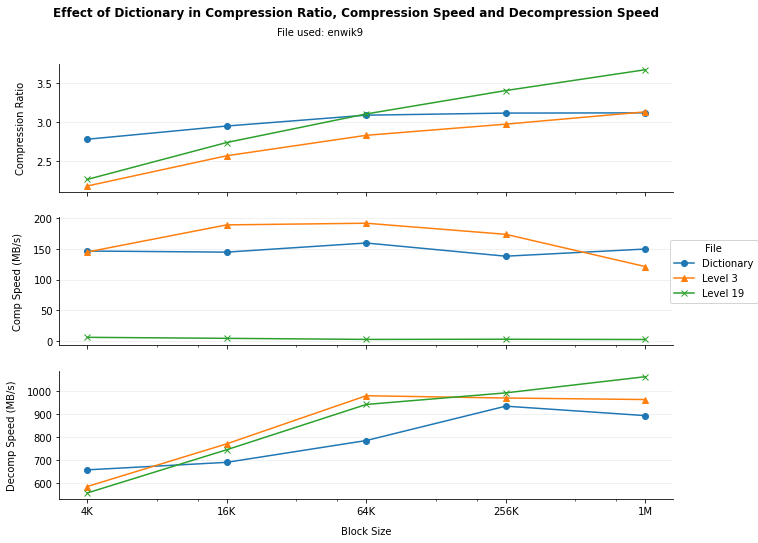

In [9]:
# GRAPH IMPLEMENTED WITH MATPLOTLIB SUBPLOTS

# Creation of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
fig.suptitle("Effect of Dictionary in Compression Ratio, Compression Speed and Decompression Speed", weight="bold")
fig.text(s=f"File used: {file}", y=0.93, x=0.4)

markers = ["o", "^", "x", "s", "."] # Possible markers to differentiate the plots for each file (allows for 5 different files)

columns = ["compression_ratio", "compression_speed", "decompression_speed"] 
x = [pow(4,i) for i in range(1, 6)] # Array for ticks in X axis 

benchmarks = ["dic"] + [f"l{level}" for level in compression_levels]

for (i, benchmark) in enumerate(benchmarks):
        
    # semilogx is used for these plots as it allows a logaritmic
    # progression in the x axis. Block sizes are selected following a progression of base 4
    ax1.semilogx(x, df[f"compression_ratio_{benchmark}"], label=benchmark, base=4, marker=markers[i])
    ax2.semilogx(x, df[f"compression_speed_{benchmark}"], label=benchmark, base=4, marker=markers[i])
    ax3.semilogx(x, df[f"decompression_speed_{benchmark}"], label=benchmark, base=4, marker=markers[i])

# AXES STYLES

# Y axis
ax1.set_ylabel("Compression Ratio", labelpad=10)
ax2.set_ylabel("Comp Speed (MB/s)", labelpad=10)
ax3.set_ylabel("Decomp Speed (MB/s)", labelpad=10)

# X axis
ax3.set_xlabel("Block Size", labelpad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(block_sizes)
    
# Labels to identify each file
fig.legend([ax1, ax2, ax3],
           labels=["Dictionary", "Level 3", "Level 19"],      
           loc="center right",
           borderaxespad=0.1,
           title="File"
          )
    
plt.show()

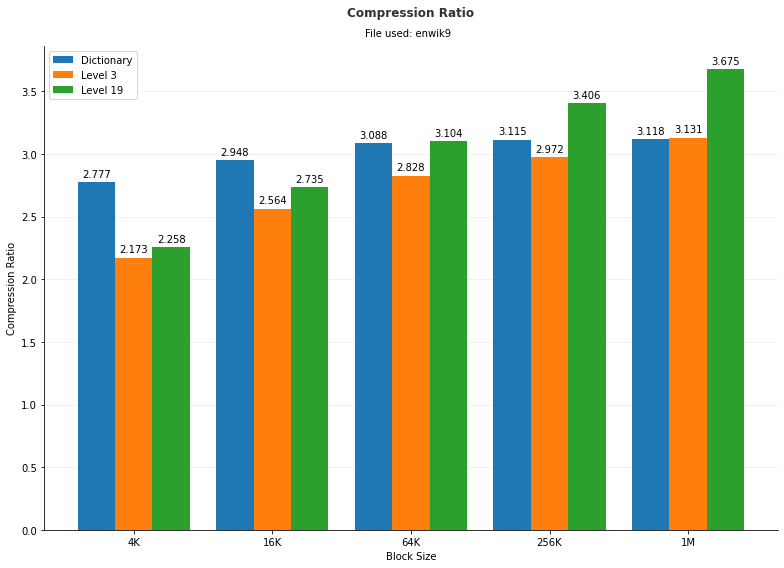

In [23]:
fig, ax = plt.subplots()

x = np.arange(len(df))
width = 0.27

bars_dic = ax.bar(x, df["compression_ratio_dic"], width, label="Dictionary")
bars_l3 = ax.bar(x + width, df["compression_ratio_l3"], width, label="Level 3")
bars_l19 = ax.bar(x + width*2, df["compression_ratio_l19"], width, label="Level 19")

ax.set_ylabel("Compression Ratio")
ax.set_xlabel("Block Size")
ax.set_xticks(x+width)
ax.set_xticklabels(df["block_size"])
ax.legend()

ax.bar_label(bars_dic, padding=3)
ax.bar_label(bars_l3, padding=3)
ax.bar_label(bars_l19, padding=3)

ax.set_title('Compression Ratio', color='#333333', pad=30, weight='bold')
fig.text(s=f"File used: {file}", y=0.93, x=0.465)

fig.tight_layout()
plt.show()

### Insights

It can be observed that the smaller the block size, the bigger is the difference in performance in favor of dictionary compression. In this case, using a dictionary, with the default compression level (level 3), was the overall best for the 4K size; specially, it shined in terms of Compression Ratio (24% improvement over Level 19).

Regarding compression ratio, Dictionary Compression was outperformed by "regular" compression with Level 19 until reaching the 64K size (even though it was still faster in compression speed). 

Level 3 surpassed the compression ratio of a dictionary until 256K size.

With this, the effectiveness of Dictionary Compression with small blocks (or small files) is proven.

## Testing different levels for Dictionary Compression

A compression level (1 to 19) can also be specified when creating and using a Dictionary. If a compression level is specified in training, the resulting dictionary is supposed to be more efficient with the target compression level.

In [10]:
# The next tests will be run with a small
# block size. In this case, 4K will be used
block_size = "4K"

In [8]:
# Train dictionary with level 3 of compression
os.system(f"zstd --train -3  -B{block_size} {file}")

Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


0

In [9]:
# Test dictionary with levels from 1 to 5
os.system(f"zstd -b1e5 -B{block_size} {file} -D dictionary")

 1#enwik9            :1000000000 -> 402965694 (2.482), 181.7 MB/s , 659.7 MB/s 
 2#enwik9            :1000000000 -> 379225912 (2.637), 181.0 MB/s , 567.8 MB/s 
 3#enwik9            :1000000000 -> 360101455 (2.777), 105.1 MB/s , 581.1 MB/s 
 4#enwik9            :1000000000 -> 380487898 (2.628),  81.5 MB/s , 525.9 MB/s 
 5#enwik9            :1000000000 -> 367904291 (2.718),  67.0 MB/s , 568.5 MB/s 


0

As it can be seen, the compression ratio was the highest with the target compression level (3). 

In [25]:
os.system(f"rm dictionary") # remove created dictionary

rm: cannot remove 'dictionary': No such file or directory


256

Now, as with "regular compression", it is expected that in Dictionary Compression lower levels provide faster compression but lower ratio (and slower decompression), when higher levels sacrifice compression speed to improve the ratio and decompression.

In [23]:
# 5 different compression levels
compression_levels = [i for i in range(1, 20, 4)]
print("Compression levels ->", compression_levels)

Compression levels -> [1, 5, 9, 13, 17]


In [26]:
df_levels = pd.DataFrame() # new DataFrame for data storing

for level in compression_levels:
    
    print(f"Compressing with level {level}...")
    
    # -- DICTIONARY BUILDING -- #
    building_command = f"zstd --train -B{block_size} -{level} {file}"
    os.system(building_command)
    
    # -- BENCHMARK -- #
    benchmark_command = f"zstd -b -B{block_size} -{level} {file} -D dictionary"
    stream = Popen(benchmark_command, 
                   shell=True,
                   stdout=PIPE,
                   stderr=PIPE)
       
    # Metrics extraction
    compression_ratio, compression_speed, decompression_speed = get_metrics(stream.stderr)
    
    # -- RESULTS STORING -- #
    df_levels = df_levels.append({
        "compression_level": level,
        "compression_ratio": compression_ratio,
        "compression_speed": compression_speed,
        "decompression_speed": decompression_speed
    }, ignore_index=True)

    
    os.system("rm dictionary")

Compressing with level 1...


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 395439257 (2.529)', ' 194.1 MB/s ', ' 688.0 MB/s \r 1#\n']
Compressing with level 5...


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 345112438 (2.898)', '  72.7 MB/s ', ' 599.9 MB/s \r 5#\n']
Compressing with level 9...


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 326995774 (3.058)', '  21.2 MB/s ', ' 518.9 MB/s \r 9#\n']
Compressing with level 13...


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 321568541 (3.110)', '  8.73 MB/s ', ' 540.3 MB/s \r13#\n']
Compressing with level 17...


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 313862082 (3.186)', '  3.71 MB/s ', ' 577.3 MB/s \r17#\n']


In [30]:
df_levels

,compression_level,compression_ratio,compression_speed,decompression_speed
0,1.0,2.529,194.10,688.0
1,5.0,2.898,72.70,599.9
2,9.0,3.058,21.20,518.9
3,13.0,3.110,8.73,540.3
4,17.0,3.186,3.71,577.3


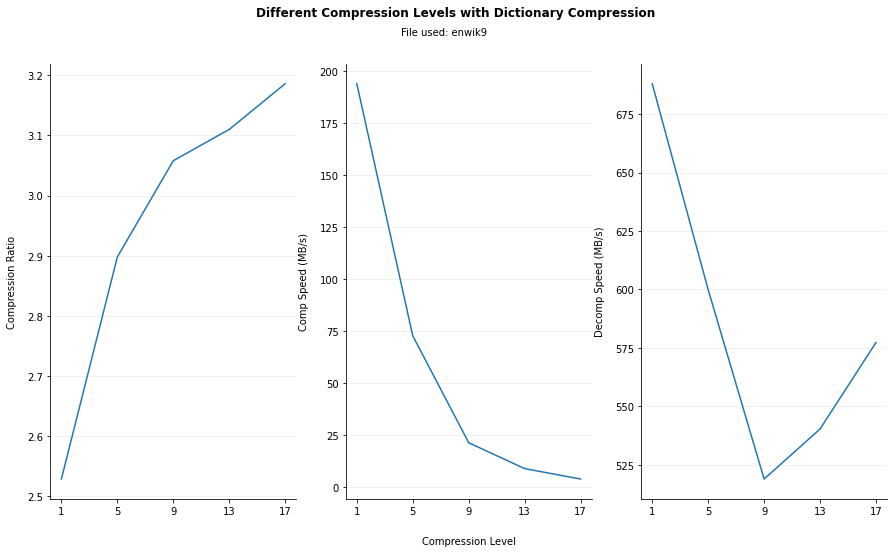

In [42]:
# GRAPH IMPLEMENTED WITH MATPLOTLIB SUBPLOTS

# Creation of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
fig.suptitle("Different Compression Levels with Dictionary Compression", weight="bold")
fig.text(s=f"File used: {file}", y=0.93, x=0.45)

# Plots
ax1.plot(df_levels["compression_level"], df_levels["compression_ratio"])
ax2.plot(df_levels["compression_level"], df_levels["compression_speed"])
ax3.plot(df_levels["compression_level"], df_levels["decompression_speed"])

# X axis
ax1.set_xticks(df_levels["compression_level"])
ax2.set_xticks(df_levels["compression_level"])
ax3.set_xticks(df_levels["compression_level"])
ax2.set_xlabel("Compression Level", labelpad=20)

# Y axis
ax1.set_ylabel("Compression Ratio", labelpad=10)
ax2.set_ylabel("Comp Speed (MB/s)", labelpad=10)
ax3.set_ylabel("Decomp Speed (MB/s)", labelpad=10)

plt.show()

### Insights

Choosing the proper compression level really depends on the use-case and what is mostly desired with compression (either a faster compression, decompression; a better ratio or a balance). 

With read-only filesystems, we suspect that they will be compressed only once and read (decompressed) many times. Thus, the most important metrics can be Compression Ratio and Decompression Speed. A good balance is achieved using the 5th level (2.9 for ratio and about 600 MB/s for decomp; even comp speed is really good). 

Now, both decompression speed and compression ratio are increasing after the 9th level, so maybe level 19th will offer the best compression ratio while having an equiparable decompression speed to that of level 5. However, there is a tremendous sacrifice with compression speed - if this can be tolerated, level 19 can maximize compression ratio. 

## Testing different sizes of Dictionary

The larger the dictionary is the more impactful it can be in compression ratio (positively) but also memory usage and speed (negatively).

The idea here is to find a "good enough" dictionary size according to block size.

NOTE: by default, dictionary size is 110KB. In zstd's documentation, it is said that normally a bigger dictionary would not be necessary.

In [16]:
dictionary_sizes = ["30K", "70K", "110K", "150K"] # 4 different sizes to be tested

Level 5 is specified when training the dictionaries. This level is also used for a "regular" compression to compare it with the different dictionary sizes.

In [17]:
compression_level = 5 # provided good results in previous tests

In [18]:
block_sizes = ["4K", "8K", "16K", "32K", "64K"] # different block sizes, powers of 4

In [19]:
# New DataFrame
df_dsizes = pd.DataFrame()

for block_size in block_sizes:
    
    row = { "block_size": block_size }
    
    # -- "REGULAR" COMPRESSION (Level 5) -- #
    stream_l5 = Popen(f"zstd -b{compression_level} -B{block_size} {file}",
                           shell=True,
                           stdout=PIPE,
                           stderr=PIPE)
   
    # Metrics extraction
    compression_ratio_l5, compression_speed_l5, decompression_speed_l5 = get_metrics(stream_l5.stderr)
    
    # Result saving
    row.update({
        "compression_ratio_l5": compression_ratio_l5,
        "compression_speed_l5": compression_speed_l5,
        "decompression_speed_l5": decompression_speed_l5
    })
    
    # -- DICTIONARY COMPRESSION -- #
    
    for dictionary_size in dictionary_sizes:
    
        # Training
        os.system(f"zstd --train -{compression_level} -B{block_size} --maxdict={dictionary_size} {file}")
    
        # Benchmarks
        stream = Popen(f"zstd -b{compression_level} -B{block_size} {file} -D dictionary", 
                      shell=True,
                      stdout=PIPE,
                      stderr=PIPE)
        
        # Metrics
        compression_ratio, compression_speed, decompression_speed = get_metrics(stream.stderr)
        
        # Result saving
        row.update({
            f"compression_ratio_d{dictionary_size}": compression_ratio,
            f"compression_speed_d{dictionary_size}": compression_speed,
            f"decompression_speed_d{dictionary_size}": decompression_speed
        })
        
        # Clearing
        os.system("rm dictionary")
        
        
    df_dsizes = df_dsizes.append(row, ignore_index=True)

['1000000000 -> 450260303 (2.221)', '  77.0 MB/s ', ' 589.8 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 30720 into file dictionary 


['1000000000 -> 358804700 (2.787)', '  81.6 MB/s ', ' 576.2 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 71680 into file dictionary 


['1000000000 -> 349014871 (2.865)', '  77.2 MB/s ', ' 589.5 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 345112438 (2.898)', '  77.4 MB/s ', ' 589.5 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 153600 into file dictionary 


['1000000000 -> 336402054 (2.973)', '  71.6 MB/s ', ' 659.3 MB/s \r 5#\n']
['1000000000 -> 407788894 (2.452)', '  90.6 MB/s ', ' 669.4 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 30720 into file dictionary 


['1000000000 -> 347940630 (2.874)', '  78.3 MB/s ', ' 587.2 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 71680 into file dictionary 


['1000000000 -> 339425796 (2.946)', '  73.5 MB/s ', ' 541.0 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 336288624 (2.974)', '  79.8 MB/s ', ' 576.1 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=537                                                                          
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 153600 into file dictionary 


['1000000000 -> 325595715 (3.071)', '  80.1 MB/s ', ' 707.7 MB/s \r 5#\n']
['1000000000 -> 376281691 (2.658)', '  89.6 MB/s ', ' 766.5 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 30720 into file dictionary 


['1000000000 -> 337028397 (2.967)', '  81.7 MB/s ', ' 630.9 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 71680 into file dictionary 


['1000000000 -> 328408850 (3.045)', '  83.5 MB/s ', ' 617.3 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 325049215 (3.076)', '  81.6 MB/s ', ' 611.3 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 153600 into file dictionary 


['1000000000 -> 318804593 (3.137)', '  86.9 MB/s ', ' 676.1 MB/s \r 5#\n']
['1000000000 -> 359155240 (2.784)', ' 113.1 MB/s ', ' 842.4 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 30720 into file dictionary 


['1000000000 -> 327069791 (3.057)', '  84.9 MB/s ', ' 701.3 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 71680 into file dictionary 


['1000000000 -> 319865275 (3.126)', '  78.8 MB/s ', ' 661.7 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 317005604 (3.155)', '  66.1 MB/s ', ' 612.8 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 153600 into file dictionary 


['1000000000 -> 309744817 (3.228)', '  57.4 MB/s ', ' 634.6 MB/s \r 5#\n']
['1000000000 -> 343653936 (2.910)', '  99.9 MB/s ', ' 880.4 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 30720 into file dictionary 


['1000000000 -> 323339998 (3.093)', '  95.3 MB/s ', ' 777.4 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 71680 into file dictionary 


['1000000000 -> 315941551 (3.165)', '  83.2 MB/s ', ' 704.8 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 112640 into file dictionary 


['1000000000 -> 313835582 (3.186)', '  86.2 MB/s ', ' 724.8 MB/s \r 5#\n']


Trying 5 different sets of parameters                                          
k=50                                                                           
d=8
f=20
steps=4
split=75
accel=1
Save dictionary of size 153600 into file dictionary 


['1000000000 -> 304792662 (3.281)', '  70.1 MB/s ', ' 733.7 MB/s \r 5#\n']


Results in DataFrame

In [20]:
df_dsizes

,block_size,compression_ratio_l5,compression_speed_l5,decompression_speed_l5,compression_ratio_d30K,compression_speed_d30K,decompression_speed_d30K,compression_ratio_d70K,compression_speed_d70K,decompression_speed_d70K,compression_ratio_d110K,compression_speed_d110K,decompression_speed_d110K,compression_ratio_d150K,compression_speed_d150K,decompression_speed_d150K
0,4K,2.221,77.0,589.8,2.787,81.6,576.2,2.865,77.2,589.5,2.898,77.4,589.5,2.973,71.6,659.3
1,8K,2.452,90.6,669.4,2.874,78.3,587.2,2.946,73.5,541.0,2.974,79.8,576.1,3.071,80.1,707.7
2,16K,2.658,89.6,766.5,2.967,81.7,630.9,3.045,83.5,617.3,3.076,81.6,611.3,3.137,86.9,676.1
3,32K,2.784,113.1,842.4,3.057,84.9,701.3,3.126,78.8,661.7,3.155,66.1,612.8,3.228,57.4,634.6
4,64K,2.910,99.9,880.4,3.093,95.3,777.4,3.165,83.2,704.8,3.186,86.2,724.8,3.281,70.1,733.7


/tmp/ipykernel_4643/1396304521.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax1, ax2, ax3],


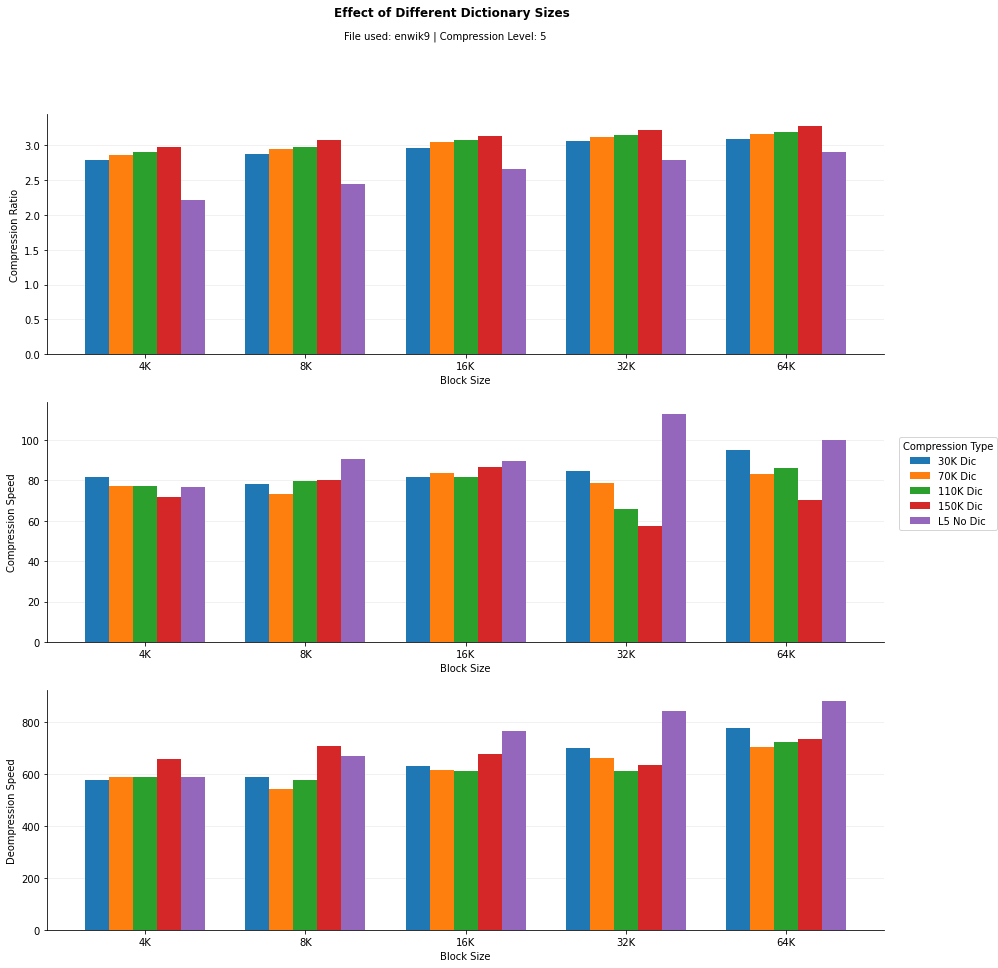

In [59]:
# GRAPH IMPLEMENTED WITH MATPLOTLIB SUBPLOTS

# Creation of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle("Effect of Different Dictionary Sizes", weight="bold")
fig.text(s=f"File used: {file} | Compression Level: {compression_level}", y=0.95, x=0.4)

x = np.arange(len(df_dsizes))
width = 0.15

# Creation of barplots
ax1_barplots = []
ax2_barplots = []
ax3_barplots = []

for (i, dictionary_size) in enumerate(dictionary_sizes):
    
    ax1.bar(x + width*i, df_dsizes[f"compression_ratio_d{dictionary_size}"],
                          width, label=f"{dictionary_size} Dic")
        
    ax2.bar(x + width*i, df_dsizes[f"compression_speed_d{dictionary_size}"],
                          width, label=f"{dictionary_size} Dic")
    
    ax3.bar(x + width*i, df_dsizes[f"decompression_speed_d{dictionary_size}"],
                          width, label=f"{dictionary_size} Dic")


# Barplot for compression without dictionary
ax1.bar(x + (len(x)-1)*width, df_dsizes[f"compression_ratio_l{compression_level}"],
                     width, label=f"L{compression_level} No Dic")

ax2.bar(x + (len(x)-1)*width, df_dsizes[f"compression_speed_l{compression_level}"],
                     width, label=f"L{compression_level} No Dic")

ax3.bar(x + (len(x)-1)*width, df_dsizes[f"decompression_speed_l{compression_level}"],
                     width, label=f"L{compression_level} No Dic")
    
    
# Ticks and axis labels
ax1.set_ylabel("Compression Ratio")
ax1.set_xlabel("Block Size")
ax1.set_xticks(x + 2*width)
ax1.set_xticklabels(df_dsizes["block_size"])

ax2.set_ylabel("Compression Speed")
ax2.set_xlabel("Block Size")
ax2.set_xticks(x + 2*width)
ax2.set_xticklabels(df_dsizes["block_size"])

ax3.set_ylabel("Deompression Speed")
ax3.set_xlabel("Block Size")
ax3.set_xticks(x + 2*width)
ax3.set_xticklabels(df_dsizes["block_size"])

# Labels to identify each file
fig.legend([ax1, ax2, ax3],
           labels=["30K Dic", "70K Dic", "110K Dic", "150K Dic", "L5 No Dic"],      
           loc="center right",
           borderaxespad=0.1,
           title="Compression Type"
          )
    
plt.show()

/tmp/ipykernel_4643/63545762.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax1, ax2, ax3],


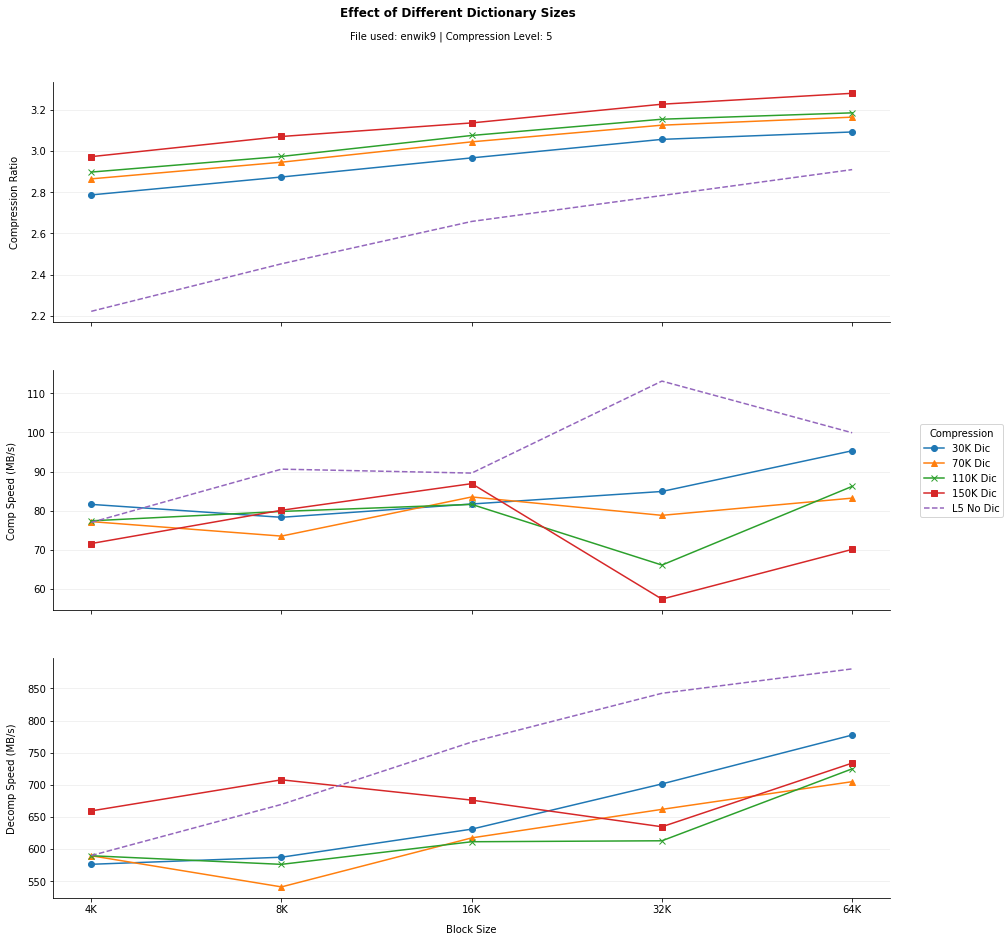

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
fig.suptitle("Effect of Different Dictionary Sizes", weight="bold", y=0.95)
fig.text(s=f"File used: {file} | Compression Level: {compression_level}", y=0.92, x=0.4)

markers = ["o", "^", "x", "s", "."] # Possible markers to differentiate the plots for each file (allows for 5 different files)

columns = ["compression_ratio", "compression_speed", "decompression_speed"] 
x = [pow(2,i) for i in range(2, 7)] # Array for ticks in X axis 

for (i, dictionary_size) in enumerate(dictionary_sizes):
        
    # semilogx is used for these plots as it allows a logaritmic
    # progression in the x axis. Block sizes are selected following a progression of base 4
    ax1.semilogx(x, df_dsizes[f"compression_ratio_d{dictionary_size}"], label=dictionary_size, base=2, marker=markers[i])
    ax2.semilogx(x, df_dsizes[f"compression_speed_d{dictionary_size}"], label=dictionary_size, base=2, marker=markers[i])
    ax3.semilogx(x, df_dsizes[f"decompression_speed_d{dictionary_size}"], label=dictionary_size, base=2, marker=markers[i])

# No Dic Compression  plot
ax1.semilogx(x, df_dsizes[f"compression_ratio_l5"], "--", label="nodic", base=2)
ax2.semilogx(x, df_dsizes[f"compression_speed_l5"], "--", label="nodic", base=2)
ax3.semilogx(x, df_dsizes[f"decompression_speed_l5"], "--", label="nodic", base=2)
    
# AXES STYLES

# Y axis
ax1.set_ylabel("Compression Ratio", labelpad=10)
ax2.set_ylabel("Comp Speed (MB/s)", labelpad=10)
ax3.set_ylabel("Decomp Speed (MB/s)", labelpad=10)

# X axis
ax3.set_xlabel("Block Size", labelpad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(block_sizes)
    
# Labels to identify each file
fig.legend([ax1, ax2, ax3],
           labels=["30K Dic", "70K Dic", "110K Dic", "150K Dic", "L5 No Dic"],      
           loc="center right",
           borderaxespad=0.1,
           title="Compression"
          )
    
plt.show()

### Insights 

* I cannot perceive a direct impact in decompression speed depending on the size of the dictionary. Even in compression speed, it is not until larger block sizes (32K and 64K) that bigger dictionaries appear to be slower.

* Compression with dictionary is always better than using no dictionary. in terms of compression ratio. From 16K block size, L5 trained dictionaries are always slower. 

* For the smallest block size. Compression annd Decompression Speeds are pretty much identical between 70K, 110K dics and L5 with no dic.

When compressing with 4K block sizes, 70K dictionaries offer the same compression and decompression speeds than the 110K size with just a .033 difference in compression ratio. Therefore, for this specific case, 70K might be a decent size.

## Proposed Compression

In [ ]:
%%capture 

BLOCK_SIZE = "4K"
DICTIONARY_SIZE = "70K"
COMPRESSION_LEVEL = 5

df = pd.DataFrame()

for i in range(50):
    
    # Dictionary Training 
    os.system(f"zstd --train -B{BLOCK_SIZE} -{COMPRESSION_LEVEL} --maxdict={DICTIONARY_SIZE} {file}")
    
    # Benchmarks
    stream = Popen(f"zstd -b{COMPRESSION_LEVEL} -B{BLOCK_SIZE} {file} -D dictionary", 
                  shell=True,
                  stdout=PIPE,
                  stderr=PIPE)
    
    # Metrics extraction
    compression_ratio, compression_speed, decompression_speed = get_metrics(stream.stderr)
    
    df = df.append({
        "compression_ratio": compression_ratio,
        "compression_speed": compression_speed,
        "decompression_speed": decompression_speed
    })
    
    os.system("rm dictionary")

Trying 5 different sets of parameters                                          
20%       